## My Task
In this part, since we were asked to predict one of the spendings from others, I decided to choose "transportation and warehousing" as a goal. In the following cells, the codes to reach this target is presented.

#### First of all, the necessary libraries are added.

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# sklearn stuff
from sklearn.metrics import mean_squared_error as MSE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split as TrainTestSplitter

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

#### Secondly, the data is loaded.
Due to the fact that it was mentioned in the lecture not to include the total spent money, the colunmn of it is dropped after loading the initial data. 

In [58]:
PATH_TO_DATA = 'Affinity-City-Daily-final.csv'
Data = pd.read_csv(PATH_TO_DATA)
Data = Data.drop(['spend_all'], axis=1) #Dropping MCC


print("The resulting data is:")
Data

The resulting data is:


,year,month,day,cityid,spend_acf,spend_aer,spend_grf,spend_hcs,spend_tws
0,2020,1,13,1,-0.00322,0.00706,0.00389,-0.03550,-0.00510
1,2020,1,13,2,0.00660,-0.07790,-0.00956,0.06040,-0.03250
2,2020,1,13,3,-0.10400,0.03340,0.01240,-0.00547,0.01810
3,2020,1,13,4,-0.03560,-0.15000,0.00405,0.03050,-0.01790
4,2020,1,13,5,-0.00770,-0.04040,0.00888,-0.00653,0.00175
...,...,...,...,...,...,...,...,...,...
12245,2020,9,13,49,-0.32600,-0.42000,-0.09140,-0.03690,-0.57100
12246,2020,9,13,50,-0.19800,-0.68700,0.37900,-0.35200,-0.55500
12247,2020,9,13,51,-0.00545,-0.29800,0.21200,0.61400,-0.32400
12248,2020,9,13,52,-0.42000,-0.73100,0.16200,-0.35200,-0.56800


#### Now the goal column is separeted from the others. 
The target is represented by "y" while the other parameters, which are in hand, are represented by "x". 

In [68]:
x = Data[Data.columns[4:8]]
y = Data[Data.columns[8]]

Representing x:

In [4]:
x

,spend_aer,spend_grf,spend_hcs,spend_tws
0,0.00706,0.00389,-0.03550,-0.00510
1,-0.07790,-0.00956,0.06040,-0.03250
2,0.03340,0.01240,-0.00547,0.01810
3,-0.15000,0.00405,0.03050,-0.01790
4,-0.04040,0.00888,-0.00653,0.00175
...,...,...,...,...
12245,-0.42000,-0.09140,-0.03690,-0.57100
12246,-0.68700,0.37900,-0.35200,-0.55500
12247,-0.29800,0.21200,0.61400,-0.32400
12248,-0.73100,0.16200,-0.35200,-0.56800


Representing y:

In [5]:
y

0       -0.00322
1        0.00660
2       -0.10400
3       -0.03560
4       -0.00770
          ...   
12245   -0.32600
12246   -0.19800
12247   -0.00545
12248   -0.42000
12249   -0.11100
Name: spend_acf, Length: 12250, dtype: float64

#### In this part 'x' and 'y' are separeted into train and test data. 

In [86]:
def splitData(x, y, train_size=0.5):
    index = int(len(x)*train_size)
    
    xTrainData = x[:index]
    xTestData  = x[index:]
    yTrainData = y[:index]
    yTestData  = y[index:]
    
    return xTrainData, xTestData, yTrainData, yTestData

In [70]:
xTrainData, xTestData, yTrainData, yTestData = splitData(x, y)

#### Now it is time to train the regression models.
It is crucial to find a degree for polynomials so that the Mean Square Error(MSE) be the least amount possible. Therefore, before training, the best degree is found. 

In [89]:
def fitAndPredict(desiredDeg, xTrainData, yTrainData):
    polyReg = Pipeline([
            ("std_scaler", StandardScaler()),
            ("poly_features", PolynomialFeatures(degree=desiredDeg, include_bias=False)),
            ("lin_reg", LinearRegression()),
        ])
    polyReg.fit(xTrainData, yTrainData)
    
    yTrainPred = polyReg.predict(xTrainData)
    yTestPred = polyReg.predict(xTestData)
    
    return yTrainPred, yTestPred

def calcTrainTestMSE(yTrainData, yTestData, yTrainPred, yTestPred):
    trainMSE = MSE(yTrainData, yTrainPred)
    testMSE = MSE(yTestData, yTestPred)
    
    return trainMSE, testMSE

def calcTrainTestMSEs(xTrainData, yTrainData, xTestData, yTestData):
    testMSEs, trainMSEs = [], []

    for d in range(1,6):
        yTrainPred, yTestPred = fitAndPredict(d, xTrainData, yTrainData)
        trainMSE, testMSE = calcTrainTestMSE(yTrainData, yTestData, yTrainPred, yTestPred)
        
        testMSEs.append(testMSE)
        trainMSEs.append(trainMSE)
            
    return trainMSEs, testMSEs
    
    
    

Text(0.5, 0, 'Degree')

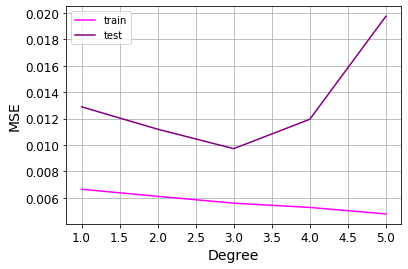

In [90]:
trainMSEs, testMSEs = calcTrainTestMSEs(xTrainData, yTrainData, xTestData, yTestData)
degrees = [i for i in range(1, 6)]
plt.plot(degrees, trainMSEs, label='train', color='magenta')
plt.plot(degrees, testMSEs, label='test', color='purple')
plt.grid()
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Degree')

Based on the above plot, the best dgree to fit the model is 3. Therefore, in the following cell using the stated dgree, training is preceded. 

In [91]:
yTrainPred, yTestPred = fitAndPredict(3, xTrainData, yTrainData)

#### Now plotting the result shows how successful the regression worked.

Text(0.5, 1.0, 'Train data')

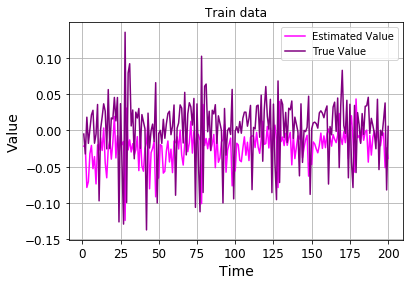

In [92]:
time = [i for i in range(1, 201)]
plt.plot(time, yTrainPred[0:200], label='Estimated Value', color='magenta')
plt.plot(time, yTrainData[0:200], label='True Value', color='purple')
plt.grid()
plt.legend()
plt.ylabel('Value')
plt.xlabel('Time')
plt.title('Train data')

Text(0.5, 1.0, 'Test data')

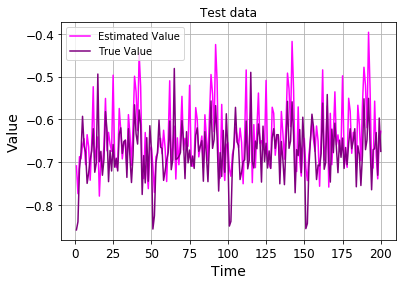

In [93]:
time = [i for i in range(1, 201)]
plt.plot(time, yTestPred[0:200], label='Estimated Value', color='magenta')
plt.plot(time, yTestData[0:200], label='True Value', color='purple')
plt.grid()
plt.legend()
plt.ylabel('Value')
plt.xlabel('Time')
plt.title('Test data')